In [184]:
import mir_eval
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import dataloader
import utils

def createChordTemplates():
    """
    creates templates for Major and Minor chords
    return: list Chord_labels , ndarray templates (24x12)
    """
    pitch_class = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]
    chord_labels = ["N"]
    templates = np.zeros((25,12),dtype=float)
    # major chords
    templates[0,:] = 1/12
    for i,x in enumerate(pitch_class):
        chord_labels.append(f"{x}")
        templates[i+1,:] = np.roll(mir_eval.chord.quality_to_bitmap('maj'),i)
    # minor chords
    for i,x in enumerate(pitch_class):
        chord_labels.append(f"{x}:min")
        templates[i+13,:] = np.roll(mir_eval.chord.quality_to_bitmap('min'),i)
    return chord_labels,templates

def plotTemplates(labels,templates):
    fig,ax = plt.subplots()
    ax.imshow(templates)
    ax.set_xticks([0,2,4,5,7,9,11])
    ax.set_xticklabels(["C","D","E","F","G","A","B"])
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels);
    return fig

dataset = dataloader.MIRDataset("beatles",use_deep_chroma=True,align_chroma=True)
track_ids = dataset.getTrackIDs()

y,t_chroma,chroma,ref_intervals,ref_labels = dataset[track_ids[0]]


LOADING AUDIO: 
01_-_It_Won't_Be_Long ID: 0201


[0.74777891 2.3638218  2.15717787 2.6184932  1.80575532 2.3985126
 2.48082405 1.93532395 2.32641852 2.05854851 2.58491415 2.15861696
 2.03163373 2.01478463 2.33442682 2.6247257  1.8316775  2.35474873
 2.23033673 2.40143269 2.12646228 2.04947543 2.65807301 1.94155645
 2.3523407 ]


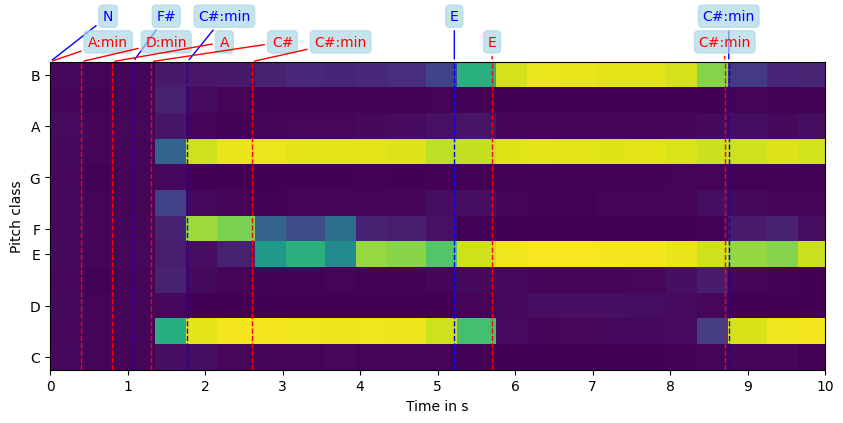

In [204]:

# CHORD ESTIMATION USING TEMPLATES
labels,templates = createChordTemplates()
max_vals = np.max(chroma, axis=1)
chroma_norm = chroma / max_vals[:,None]
correlation = np.dot(templates,chroma_norm.T)
est_labels_unfiltered = [labels[np.argmax(correlation[:,i])] for i in range(chroma.shape[0])]
est_intervals = []
est_labels = []
t_start = 0
for i,(label_t0,label_t1) in enumerate(zip(est_labels_unfiltered[:-1],est_labels_unfiltered[1:])):
    if label_t0 != label_t1:
        est_labels.append(label_t0)
        est_intervals.append([t_start,t_chroma[i]])
        t_start = t_chroma[i]
est_intervals = np.array(est_intervals)

# ##########################


# Define the interval for the annotations
time = (0,10)
fig, ax = plt.subplots(figsize=(10,4))

def addAnnotations(ax,intervals,labels,ylim=11.5,y=0.5,color='r',time=(0,10)):
    bbox_args = dict(boxstyle="round", color='lightblue',alpha=0.7)
    arrow_args = dict(arrowstyle="-",color=color)
    prev_x = 0
    for i, label in enumerate(labels):
        timestamp = intervals[i,0]
        if time[0] <= timestamp <= time[1]:
            if timestamp-prev_x < 0.75:
                x_pos = prev_x + 0.75 # Shift label to the right
            else:
                x_pos = timestamp
            prev_x = x_pos
            # Create a text box with the label and aligned to the timestamp
            ax.annotate(label,(timestamp,ylim),xytext=(x_pos, y),bbox=bbox_args,arrowprops=arrow_args,color=color, ha='center', va='bottom',)
            ax.vlines(timestamp,-0.5,ylim,color=color,linestyles='--',linewidth=1)
addAnnotations(ax,ref_intervals,ref_labels,11.5,13,'b',time)
addAnnotations(ax,est_intervals,est_labels,11.5,12,'r',time)

utils.plotChroma(ax,chroma,time);
